In [2]:
"""Developers
Neil Danait, Vaibhav Srikaran, Nitin Manivasagan, Sampath Duddu, Ronak Modi
"""

import scipy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pylab as pl
import csv
import json
import os
import NFLFileLogistics
from scipy import stats
%matplotlib inline

game1Plays ='./data/Game1/game1plays'
teamPlays ='./data/Game1/TeamRosters'
game2Plays ='./data/Game1/game2plays'
game3Plays = './data/Game1/game3plays'

positionIds = ["OT", "RB", "OL"] #SelfReference

metrics = ["outside" , "inside", "speed", "passCatching", "shortYardage"]
rb_dict = {}
rb_list = []
rb_list_name = {}
ot_list = []
ol_list = []
rbIDMetricStorage = {}
runningBackRatios = {}
insideRBRatio = {}
outsideRBRatio = {}
speedRBRatio = {}
leagueAverages = {}
playerMetricRatio = {}
playerMetricScores = {}

"""For team json file in TeamRoster, retrieves all ID's for provided position"""
def getPlayers():
    teamInformationDict = NFLFileLogistics.getJSONFiles(teamPlays)
    for fileName in teamInformationDict:
        roster = NFLFileLogistics.loadTeamJSONFile(fileName) 
        for player in roster["teamPlayers"]:
            if player["positionGroup"] == "RB":
                rb_list.append((player["nflId"], roster["team"]["abbr"], player["displayName"]))
            if player["position"] == "OT":
                ot_list.append((player["nflId"], roster["team"]["abbr"]))
            if player["positionGroup"] == "OL":
                ol_list.append((player["nflId"], roster["team"]["abbr"]))

def make_rb_dict():
    playInfoDict = NFLFileLogistics.getJSONFiles(game1Plays)
    for play_file in playInfoDict:
        play = NFLFileLogistics.loadJSONFile1(play_file)
        for running_back in rb_list:
            for stat_getter in play["play"]["playStats"]:
                for key in stat_getter:
                    if key == "nflId":
                        if stat_getter[key] == running_back[0]:
                            if running_back[0] not in rb_dict:
                                rb_dict[running_back[0]] = []
                                rb_dict[running_back[0]].append((play["gameId"], play["ngsPlayId"], running_back[1]))
                            else :
                                if ((play["gameId"], play["ngsPlayId"], running_back[1]) not in rb_dict[running_back[0]]) :
                                    rb_dict[running_back[0]].append((play["gameId"], play["ngsPlayId"], running_back[1]))
                               
    playInfoDict = NFLFileLogistics.getJSONFiles(game2Plays)
    for play_file2 in playInfoDict:
        play = NFLFileLogistics.loadJSONFile2(play_file2)
        for running_back in rb_list:
            for stat_getter in play["play"]["playStats"]:
                for key in stat_getter:
                    if key == "nflId":
                        if stat_getter[key] == running_back[0]:
                            if running_back[0] not in rb_dict:
                                rb_dict[running_back[0]] = []
                                rb_dict[running_back[0]].append((play["gameId"], play["ngsPlayId"], running_back[1]))
                            else :
                                if ((play["gameId"], play["ngsPlayId"], running_back[1]) not in rb_dict[running_back[0]]) :
                                    rb_dict[running_back[0]].append((play["gameId"], play["ngsPlayId"], running_back[1]))  

    playInfoDict = NFLFileLogistics.getJSONFiles(game3Plays)
    for play_file3 in playInfoDict:
        play = NFLFileLogistics.loadJSONFile3(play_file3)
        for running_back in rb_list:
            for stat_getter in play["play"]["playStats"]:
                for key in stat_getter:
                    if key == "nflId":
                        if stat_getter[key] == running_back[0]:
                            if running_back[0] not in rb_dict:
                                rb_dict[running_back[0]] = []
                                rb_dict[running_back[0]].append((play["gameId"], play["ngsPlayId"], running_back[1]))
                            else :
                                if ((play["gameId"], play["ngsPlayId"], running_back[1]) not in rb_dict[running_back[0]]) :
                                    rb_dict[running_back[0]].append((play["gameId"], play["ngsPlayId"], running_back[1]))  
        
def calculateInsideRun(rb_play_dict):
    for rbID in rb_play_dict:
        total_inside_plays = 0
        total_inside_yards = 0
        for ngsGameandPlayID in rb_play_dict[rbID]:
            game_num = ngsGameandPlayID[0]
            if (game_num == 1 or game_num == 2 or game_num == 3): #Check Game
                ngsPlayID_string = str(ngsGameandPlayID[1])
                tempFile = None
                if game_num == 1:
                    tempFile = NFLFileLogistics.loadJSONFile1(ngsPlayID_string + ".json")
                elif game_num == 2:
                    tempFile = NFLFileLogistics.loadJSONFile2(ngsPlayID_string + ".json")
                else: 
                    tempFile = NFLFileLogistics.loadJSONFile3(ngsPlayID_string + ".json")
                if tempFile["play"]["playType"] == "play_type_rush":
                    offensive_tackles_loc = offensive_tackles_y(tempFile)
                    line_of_scrimmage = tempFile["play"]["absoluteYardlineNumber"]
                    play_stats = tempFile["play"]["playStats"]
                    for play_stat in play_stats:
                        if "nflId" in play_stat:
                            if play_stat["nflId"] == rbID:
                                for trackingData in tempFile["homeTrackingData"]:
                                    if play_stat["yards"] < 0:
                                        if "event" in trackingData:
                                            if trackingData["event"] == "playStopped":
                                                if trackingData["playerTrackingData"]["y"] >= offensive_tackles_loc[0] and trackingData["playerTrackingData"]["y"] <= offensive_tackles_loc[1]:
                                                    total_inside_plays += 1 
                                                    total_inside_yards += play_stat["yards"]
                                    else:
                                        y_loc = min_and_max(trackingData, rbID, line_of_scrimmage)
                                        if y_loc >= offensive_tackles_loc[0] and y_loc <= offensive_tackles_loc[1]:
                                            total_inside_plays += 1 
                                            total_inside_yards += play_stat["yards"]
                                for trackingData in tempFile["awayTrackingData"]:
                                    if play_stat["yards"] < 0:
                                        if "event" in trackingData:
                                            if trackingData["playerTrackingData"]["event"] == "playStopped":
                                                if trackingData["playerTrackingData"]["y"] >= offensive_tackles_loc[0] and trackingData["playerTrackingData"]["y"] <= offensive_tackles_loc[1]:
                                                    total_inside_plays += 1 
                                                    total_inside_yards += play_stat["yards"]
                                    else:
                                        y_loc = min_and_max(trackingData, rbID, line_of_scrimmage)
                                        if y_loc >= offensive_tackles_loc[0] and y_loc <= offensive_tackles_loc[1]:
                                            total_inside_plays += 1 
                                            total_inside_yards += play_stat["yards"]
        if total_inside_plays == 0:
            insideRBRatio[rbID] = 0
        else:
            insideRBRatio[rbID] = float(total_inside_yards) / float(total_inside_plays)

def calculateOutsideRun(rb_play_dict):
    for rbID in rb_play_dict:
        total_outside_plays = 0
        total_outside_yards = 0
        for ngsGameandPlayID in rb_play_dict[rbID]:
            game_num = ngsGameandPlayID[0]
            if (game_num == 1 or game_num == 2 or game_num == 3): #Check Game
                ngsPlayID_string = str(ngsGameandPlayID[1])
                tempFile = None
                if game_num == 1:
                    tempFile = NFLFileLogistics.loadJSONFile1(ngsPlayID_string + ".json")
                elif game_num == 2:
                    tempFile = NFLFileLogistics.loadJSONFile2(ngsPlayID_string + ".json")
                else: 
                    tempFile = NFLFileLogistics.loadJSONFile3(ngsPlayID_string + ".json")
                if tempFile["play"]["playType"] == "play_type_rush":
                    offensive_tackles_loc = offensive_tackles_y(tempFile)
                    line_of_scrimmage = tempFile["play"]["absoluteYardlineNumber"]
                    play_stats = tempFile["play"]["playStats"]
                    for play_stat in play_stats:
                        if "nflId" in play_stat:
                            if play_stat["nflId"] == rbID:
                                for trackingData in tempFile["homeTrackingData"]:
                                    if play_stat["yards"] < 0:
                                        if "event" in trackingData:
                                            if trackingData["event"] == "playStopped":
                                                if trackingData["playerTrackingData"]["y"] < offensive_tackles_loc[0] or trackingData["playerTrackingData"]["y"] > offensive_tackles_loc[1]:
                                                    total_outside_plays += 1 
                                                    total_outside_yards += play_stat["yards"]
                                    else:
                                        y_loc = min_and_max(trackingData, rbID, line_of_scrimmage)
                                        if y_loc < offensive_tackles_loc[0] or y_loc > offensive_tackles_loc[1]:
                                            total_outside_plays += 1 
                                            total_outside_yards += play_stat["yards"]
                                for trackingData in tempFile["awayTrackingData"]:
                                    if play_stat["yards"] < 0:
                                        if "event" in trackingData:
                                            if trackingData["playerTrackingData"]["event"] == "playStopped":
                                                if trackingData["playerTrackingData"]["y"] < offensive_tackles_loc[0] or trackingData["playerTrackingData"]["y"] > offensive_tackles_loc[1]:
                                                    total_outside_plays += 1 
                                                    total_outside_yards += play_stat["yards"]
                                    else:
                                        y_loc = min_and_max(trackingData, rbID, line_of_scrimmage)
                                        if y_loc < offensive_tackles_loc[0] or y_loc > offensive_tackles_loc[1]:
                                            total_outside_plays += 1 
                                            total_outside_yards += play_stat["yards"]
        if total_outside_plays == 0:
            outsideRBRatio[rbID] = 0
        else:
            outsideRBRatio[rbID] = float(total_outside_yards) / float(total_outside_plays)

def speed(runningPlayDict):
    for rbID in runningPlayDict:
        speed_array = []
        for ngsGameandPlayID in runningPlayDict[rbID]:
            max_speed = 0
            game_num = ngsGameandPlayID[0]
            tempFile = None
            if (game_num == 1 or game_num == 2 or game_num == 3): #Check Game
                ngsPlayID_string = str(ngsGameandPlayID[1])  
                if game_num == 1:
                    tempFile = NFLFileLogistics.loadJSONFile1(ngsPlayID_string + ".json")
                elif game_num == 2:
                    tempFile = NFLFileLogistics.loadJSONFile2(ngsPlayID_string + ".json")
                else: 
                    tempFile = NFLFileLogistics.loadJSONFile3(ngsPlayID_string + ".json")
                incomplete = False
            if tempFile["play"]["playType"] == "play_type_rush":
                for playStat in tempFile["play"]["playStats"]:
                    if "nflId" in playStat:
                        if playStat["nflId"] == rbID:
                            if (playStat["statId"] == 10 or playStat["statId"] == 11) and playStat["yards"] >= 5:  
                                for tracking_data in tempFile["homeTrackingData"]:
                                   if tracking_data["nflId"] == rbID:
                                        for player_data in tracking_data["playerTrackingData"]:
                                            max_speed = max(max_speed, player_data["s"])
                                        speed_array.append(max_speed)
                                for tracking_data in tempFile["awayTrackingData"]:
                                    if tracking_data["nflId"] == rbID:
                                        for player_data in tracking_data["playerTrackingData"]:
                                            max_speed = max(max_speed, player_data["s"])
                                        speed_array.append(max_speed)
        avg_speed = 0
        if len(speed_array) != 0:
            for speed in speed_array:
               avg_speed += speed
            avg_speed = avg_speed*1.0 /(len(speed_array))*1.0
            if rbID not in speedRBRatio:
                speedRBRatio[rbID] = avg_speed
        else:
            speedRBRatio[rbID] = 0

def offensive_tackles_y(play):
    max_y = 0
    min_y = 10000000000000000000
    for lineman in ol_list:
        for playerH in play["homeTrackingData"]:
            if lineman[0] == playerH["nflId"]:
                for player_data in playerH["playerTrackingData"]:
                    if "event" in player_data:
                        if player_data["event"] == "snap":
                            min_y = min(player_data["y"], min_y)
                            max_y = max(player_data["y"], max_y)
        for playerA in play["awayTrackingData"]:
            if lineman[0] == playerA["nflId"]:
                for player_data in playerA["playerTrackingData"]:
                    if "event" in player_data:
                        if player_data["event"] == "snap":
                            min_y = min(player_data["y"], min_y)
                            max_y = max(player_data["y"], max_y)
    return (min_y, max_y)

def calculateShortYardage(rb_play_dict):
    for rbID in rb_play_dict:
        totalSuccesses = 0
        totalEligiblePlays = 0
        yardsGained = 0.0
        for ngsGameandPlayID in rb_play_dict[rbID]:
            game_num = ngsGameandPlayID[0]
            if (game_num == 1 or game_num == 2 or game_num == 3): #Check Game
                ngsPlayID_string = str(ngsGameandPlayID[1])
                tempFile = None
                if game_num == 1:
                    tempFile = NFLFileLogistics.loadJSONFile1(ngsPlayID_string + ".json")
                elif game_num == 2:
                    tempFile = NFLFileLogistics.loadJSONFile2(ngsPlayID_string + ".json")
                else: 
                    tempFile = NFLFileLogistics.loadJSONFile3(ngsPlayID_string + ".json")
                if (tempFile["play"]["playType"] == "play_type_rush"):
                    if (tempFile["play"]["yardsToGo"] <= 3):

                        # For if its on the goal line, defined by being on the other team's side of the field and within 3 yards of their end zone
                        if ((ngsGameandPlayID[2] != tempFile["play"]["yardlineSide"]) and (tempFile["play"]["yardlineNumber"] <=3)):
                            totalEligiblePlays += 1
                            for playStat in tempFile["play"]["playStats"]:
                                if "nflId" in playStat:
                                    if playStat["nflId"] == rbID:
                                        yardsGained += playStat["yards"]
                                else:
                                    if playStat["statId"] == 3:
                                        totalSuccesses += 1
                                    
                        # For if its not on the goal line, but 3rd or 4th down, within 3 yards of next first down
                        else:
                            if (tempFile["play"]["down"] >= 3):
                                totalEligiblePlays += 1
                                for playStat in tempFile["play"]["playStats"]:
                                    if "nflId" in playStat:
                                        if playStat["nflId"] == rbID:
                                            yardsGained += playStat["yards"]
                                    else:
                                        if playStat["statId"] == 3:
                                            totalSuccesses += 1
        if ((totalEligiblePlays) == 0):
            calculatedTuple = (0, 0)
        else:                  
            averageYardsGained = yardsGained/(totalEligiblePlays)
            successRatio = ((totalSuccesses*1.0)/(totalEligiblePlays*1.0))
            calculatedTuple = (averageYardsGained, successRatio)
        if (rbID in rbIDMetricStorage):
            rbIDMetricStorage[rbID].append(("Short Yardage Metric", calculatedTuple))
        else:
            rbIDMetricStorage[rbID] = [("Short Yardage Metric", calculatedTuple)]

def min_and_max(trackingData, rbid, scrimmage):
    max_x = 0
    min_x = 1000
    min_y = 1000
    max_y = 0
    for track in trackingData["playerTrackingData"]:
            if scrimmage >= track["x"] and max_x < track["x"]:
                max_x = track["x"]
                max_y = track["y"]
            if scrimmage <= track["x"] and min_x > track["x"]:
                min_x = track["x"]
                max_y = track["y"]
    if max_x == min_x:
        return (max_y + min_y)  / 2
    slope = (max_y - min_y)/(max_x - min_x)
    return max_y - slope*(max_x - scrimmage)

def calculatePassCatching(runningPlayDict):
    for rbID in runningPlayDict:
        totalComplete = 0
        yardsGained = 0.0
        totalEligiblePlays = 0
        for ngsGameandPlayID in runningPlayDict[rbID]:
            game_num = ngsGameandPlayID[0]
            if (game_num == 1 or game_num == 2 or game_num == 3): #Check Game
                ngsPlayID_string = str(ngsGameandPlayID[1])
                tempFile = None
                if game_num == 1:
                    tempFile = NFLFileLogistics.loadJSONFile1(ngsPlayID_string + ".json")
                elif game_num == 2:
                    tempFile = NFLFileLogistics.loadJSONFile2(ngsPlayID_string + ".json")
                else: 
                    tempFile = NFLFileLogistics.loadJSONFile3(ngsPlayID_string + ".json")
                incomplete = False
                if (tempFile["play"]["playType"] == "play_type_pass"):
                    totalEligiblePlays += 1
                    for playStat in tempFile["play"]["playStats"]:
                        if "nflId" in playStat:
                            if playStat["nflId"] == rbID:
                                if playStat["statId"] == 21:
                                    totalComplete +=1;
                                    yardsGained += playStat["yards"]
                                elif playStat["statId"] == 22:
                                    totalComplete +=1;
                                    yardsGained += playStat["yards"]    
        
        if ((totalEligiblePlays) == 0):
            calculatedTuple = (0, 0)
        else :
            averageYardsGained = yardsGained/totalEligiblePlays
            catchSuccessRatio = (totalComplete*1.0)/(totalEligiblePlays*1.0)
            calculatedTuple = (averageYardsGained, catchSuccessRatio)

        if (rbID in rbIDMetricStorage):
            rbIDMetricStorage[rbID].append(("Pass Catching Metric", calculatedTuple))
        else:
            rbIDMetricStorage[rbID] = [("Pass Catching Metric", calculatedTuple)]


def setLeagueAverages():
    passCatchingYPC = 0.0
    passCatchingCompletionRatio = 0.0
    shortYardageYPC = 0.0
    shortYardageSuccessRatio = 0.0
    insideRunYPC = 0.0
    outsideRunYPC = 0.0
    averageMaxSpeed = 0.0

    for metricArray in rbIDMetricStorage.values():
        passCatchingYPC += metricArray[0][1][0]
        passCatchingCompletionRatio += metricArray[0][1][1]
        shortYardageYPC += metricArray[1][1][0]
        shortYardageSuccessRatio += metricArray[1][1][1]
        insideRunYPC += metricArray[2][1]
        outsideRunYPC += metricArray[3][1]
        averageMaxSpeed += metricArray[4][1]

    numberPlayers =  len(rbIDMetricStorage)

    passCatchingYPC /= numberPlayers
    passCatchingCompletionRatio /= numberPlayers
    shortYardageYPC /= numberPlayers
    shortYardageSuccessRatio /= numberPlayers
    insideRunYPC /= numberPlayers
    outsideRunYPC /= numberPlayers
    averageMaxSpeed /= numberPlayers

    leagueAverages["passCatchingYPC"] =  passCatchingYPC
    leagueAverages["passCatchingCompletionRatio"] =passCatchingCompletionRatio
    leagueAverages["shortYardageYPC"] = shortYardageYPC
    leagueAverages["shortYardageSuccessRatio"] = shortYardageSuccessRatio
    leagueAverages["insideRunYPC"] = insideRunYPC
    leagueAverages["outsideRunYPC"] = outsideRunYPC
    leagueAverages["averageMaxSpeed"] =averageMaxSpeed

def calcRBOutsideYardage():
    for rbID in rbIDMetricStorage.keys():
        playerMetricRatio[rbID] = []
        finalResult = rbIDMetricStorage[rbID][3][1] / leagueAverages["outsideRunYPC"]
        playerMetricRatio[rbID].append(("outsideRatio", finalResult))
    calcRBInsideYardage()

def calcRBInsideYardage():
    for rbID in rbIDMetricStorage.keys():
        finalResult = rbIDMetricStorage[rbID][2][1] / leagueAverages["insideRunYPC"]
        playerMetricRatio[rbID].append(("insideRatio", finalResult))
    calcRBopenFieldRunning()

def calcRBopenFieldRunning():
    for rbID in rbIDMetricStorage.keys():
        finalResult = rbIDMetricStorage[rbID][4][1] / leagueAverages["averageMaxSpeed"]
        playerMetricRatio[rbID].append(("speedRatio", finalResult))
    calcRBpassCatching()

def calcRBpassCatching():
    for rbID in rbIDMetricStorage.keys():
        partYPC = rbIDMetricStorage[rbID][0][1][0] / leagueAverages["passCatchingYPC"]
        partCompletionRatio = rbIDMetricStorage[rbID][0][1][1] / leagueAverages["passCatchingCompletionRatio"]
        finalResult = partYPC + partCompletionRatio
        playerMetricRatio[rbID].append(("passCatchingRatio", finalResult))
    calcRBshortYardage()

def calcRBshortYardage():
    for rbID in rbIDMetricStorage.keys():
        partYPC = rbIDMetricStorage[rbID][1][1][0] / leagueAverages["shortYardageYPC"]
        partCompletionRatio = rbIDMetricStorage[rbID][1][1][1] / leagueAverages["shortYardageSuccessRatio"]
        finalResult = partYPC + partCompletionRatio
        playerMetricRatio[rbID].append(("shortYardageRatio", finalResult))

def setScoresForEachMetric():
    index = 0
    while index < 5 :
        rbIDs = []
        tempArray = []
        for rbId, listofMetricRatios in playerMetricRatio.items():
            rbIDs.append(rbId)
            tempArray.append(listofMetricRatios[index][1])
        a = np.array(tempArray)
        zscores = stats.zscore(a)

        for i in range(0, len(rbIDs)):
            if index == 0:
                playerMetricScores[rbIDs[i]] = []
            zscore = zscores[i]
            score = stats.norm.cdf(zscore) * 20
            playerMetricScores[rbIDs[i]].append((metrics[index], score))

        index+=1

In [3]:
getPlayers()
make_rb_dict()
calculatePassCatching(rb_dict)
calculateShortYardage(rb_dict)
calculateInsideRun(rb_dict)
calculateOutsideRun(rb_dict)
speed(rb_dict)

In [4]:
print("******InsideRBRatio******")
print (insideRBRatio)
print("******OutsideRBRatio******")
print (outsideRBRatio)
print("******SpeedRBRatio******")
print (speedRBRatio)
print("******RunningBackDictionary******")
print (rb_dict)
print("******RunningBackIDMetricStorage******")
print (rbIDMetricStorage)

******InsideRBRatio******
{2552483: 4.2, 2552388: 2.5, 2495173: 1.3333333333333333, 2539272: 1.4, 2553129: 0, 2552394: 6.333333333333333, 2553451: 5.545454545454546, 2532876: 1.0, 2530702: 2.5555555555555554, 2506416: 4.461538461538462, 2550419: 7.0, 2541556: 0.3333333333333333, 2541173: 3.68, 2550486: 3.3636363636363638, 2536056: 8.0, 2495326: 0, 2543514: 2.9375, 2552476: 1.0, 4445: 0, 2531230: 0}
******OutsideRBRatio******
{2552483: 5.698275862068965, 2552388: 2.671875, 2495173: 1.5121951219512195, 2539272: 6.007246376811594, 2553129: 0, 2552394: 6.333333333333333, 2553451: 3.7914438502673797, 2532876: 4.046153846153846, 2530702: 6.3803921568627455, 2506416: 4.0504731861198735, 2550419: 7.0, 2541556: 14.301587301587302, 2541173: 3.665768194070081, 2550486: 3.2966507177033493, 2536056: 8.536585365853659, 2495326: 0, 2543514: 3.3535031847133756, 2552476: 1.0, 4445: 0, 2531230: 0}
******SpeedRBRatio******
{2552483: 6.688, 2552388: 0, 2495173: 0, 2539272: 7.449999999999999, 2553129: 0, 2

In [5]:
for ID in insideRBRatio:
    if ID in rbIDMetricStorage:
        rbIDMetricStorage[ID].append(("Inside Run Metric", insideRBRatio[ID]))
    else:
        rbIDMetricStorage[ID] = []
        rbIDMetricStorage[ID].append(("Inside Run Metric", insideRBRatio[ID]))

for ID in outsideRBRatio:
    if ID in rbIDMetricStorage:
        rbIDMetricStorage[ID].append(("Outside Run Metric", outsideRBRatio[ID]))
    else:
        rbIDMetricStorage[ID] = []
        rbIDMetricStorage[ID].append(("Outside Run Metric", outsideRBRatio[ID]))

for ID in speedRBRatio:
    if ID in rbIDMetricStorage:
        rbIDMetricStorage[ID].append(("Speed Run Metric", speedRBRatio[ID]))
    else:
        rbIDMetricStorage[ID] = []
        rbIDMetricStorage[ID].append(("Speed Run Metric", speedRBRatio[ID]))

setLeagueAverages()
calcRBOutsideYardage()
setScoresForEachMetric()

In [6]:
print("******LeagueAverages******")
print (leagueAverages)
print("******PlayerMetricRatio******")
print (playerMetricRatio)
print("******PlayerMetricScores******")
print (playerMetricScores)

******LeagueAverages******
{'insideRunYPC': 2.7821842463092468, 'shortYardageYPC': 1.4083333333333334, 'passCatchingCompletionRatio': 0.5166666666666666, 'averageMaxSpeed': 4.21685238095238, 'shortYardageSuccessRatio': 0.275, 'passCatchingYPC': 3.206666666666666, 'outsideRunYPC': 4.0822741748748355}
******PlayerMetricRatio******
{2552483: [('outsideRatio', 1.3958581952040683), ('insideRatio', 1.5096052698780036), ('speedRatio', 1.5860171037074597), ('passCatchingRatio', 2.247334182818054), ('shortYardageRatio', 0.0)], 2552388: [('outsideRatio', 0.6545065043510756), ('insideRatio', 0.8985745654035735), ('speedRatio', 0.0), ('passCatchingRatio', 0.0), ('shortYardageRatio', 0.0)], 2495173: [('outsideRatio', 0.37042958340679905), ('insideRatio', 0.47923976821523917), ('speedRatio', 0.0), ('passCatchingRatio', 0.0), ('shortYardageRatio', 4.346422807961269)], 2531230: [('outsideRatio', 0.0), ('insideRatio', 0.0), ('speedRatio', 0.0), ('passCatchingRatio', 0.0), ('shortYardageRatio', 0.0)], 2

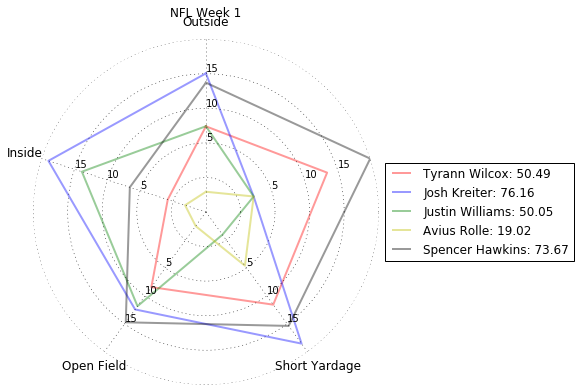

In [7]:
""" Printing out the graph """
class Radar(object):

    def __init__(self, fig, titles, labels, rect=None):
        if rect is None:
            rect = [0.1, 0.1, 0.8, 0.8]

        self.n = len(titles) 
        self.angles = np.arange(90, 90+360, 360.0/self.n)
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i) 
                         for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, fontsize=12)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.set_title("NFL Week 1")
        self.ax.plot(angle, values, *args, **kw)

titles = ["Outside", "Inside", "Open Field", "Short Yardage" , "Pass Catch"]
labels = [
    ['','5','10','15',''],
    ['','5','10','15',''],
    ['','5','10','15',''],
    ['','5','10','15',''], 
    ['','5','10','15','']
]

fig = pl.figure(figsize=(6, 6))

titles = ["Outside", "Inside", "Open Field", "Short Yardage" , "Pass Catch"]
labels = [
    ['','5','10','15',''],
    ['','5','10','15',''],
    ['','5','10','15',''],
    ['','5','10','15',''],
    ['','5','10','15','']
]

colors = ["r" , "b" , "g", "y", "k"]
plots = []
color_num = 0

for rb in rb_list:
    scores = []
    overall_score = 0
    if rb[0] in playerMetricScores:
        for score in playerMetricScores[rb[0]]:
            scores.append(score[1]/4)
        overall_scores = (5.)*scores[0] + (5.)*scores[1] + (20./6)*scores[2] + (20./6)*scores[3] + (20./6)*scores[4]
        overall_scores = int(overall_scores *100)/ 100.
        if color_num <= 4:
            plots.append((scores,  "-", 2, colors[color_num], 0.4, rb[2] + ": " + str(overall_scores)))
            color_num = color_num + 1

radar = Radar(fig, titles, labels)
for elem in plots:
    radar.plot(elem[0], elem[1], lw=elem[2], color=elem[3], alpha=elem[4], label=elem[5])
radar.ax.legend()
radar.ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
